<a href="https://colab.research.google.com/github/premonish/relax_inc/blob/main/Relax_Inc_Take_Home_Challenge_DONE_%5BPrem_Ananda%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEM STATEMENT**
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify **which factors predict future user adoption.**

**Which variables best predict future user adoption?**

Adoption:  >= 3 login days within a 7 day period.


---
##**Approach** 
1. Simplify DataFrame to features that may have an impact
2. Create a binary Adoption feature: 1 = adopted_user 0 = not adopted_user
3. Identify the Feature Importance related to adopted users using regression.
---

###**IMPORT PACKAGES**

In [40]:
# import packages/ libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta 

###**LOAD DATA**

In [41]:
# import data
path1 = 'https://raw.githubusercontent.com/premonish/relax_inc/main/data/takehome_user_engagement.csv'
path2 = 'https://raw.githubusercontent.com/premonish/relax_inc/main/data/takehome_users.csv'
engagement = pd.read_csv(path1)
users = pd.read_csv(path2, encoding='latin-1') # needed to use 'latin-1' encoding

In [42]:
engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [43]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


###**CLEAN DATA**
We know from the Metadata that the object_id = user's id. Let's change the name in the user dataframe to match the engagement dataframe.

In [44]:
users.rename(columns={"object_id": "user_id"}, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


**NOTE:** last_session_creation_time and invited_by_user_id columns contain null values. 

last_session_creation_time having a null value could mean that the user never logged in after their initial sign-up. If this is the case, they would not be an adopted user by definition (3 or more logins in a 7-day period). We will investigate this further.

invited_by_user_id's null values most likely represent a user that simply created an account without an explicit referral.  




---


## **1. Simplify Dataframe to features that may have an impact.**
---

In [6]:
print(users.shape)
users.head(1)

(12000, 10)


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0


We can drop the columns: name, email, 

In [7]:
users.drop(['name','email'], axis=1,inplace=True)
print(users.shape)
users.head(1)

(12000, 8)


,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0


In [8]:
users.invited_by_user_id.value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
           ..
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

There are 2564 unique 'invited_by_user_id' values. The maximum # of invites is 13 by user_id 10741. We can investigate if this will help predict adopted users.

In [9]:
users.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

There are 417 unique 'org_id' values. The maximum # of values is 319 by org_id '0'. '0' likely represents a null value since there are zero null values in the column. org_id '1' has 233 counts. We can also investigate if the org_id correlates with adopted users.

###**TRANSFORM DATA**

In [10]:
# convert time_stamp to datetime format
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [11]:
# convert time_stamp to datetime format
users.creation_time = pd.to_datetime(users.creation_time, format='%Y-%m-%d %H:%M:%S')
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

In [12]:
# new feature:  compute user acct_age in days
users['acct_age'] = users.last_session_creation_time - users.creation_time
users['acct_age'] = users.acct_age.dt.days

3177

---
##**2. Create a binary 'adopted_user' feature.** 
[adopted_user : 1 ,    non-adopted_user : 0]
---

In [17]:
# convert time_stamp to datetime format
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [18]:
# "Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period"

def adopted_user(df):
    df['date'] = df['time_stamp'].dt.date      # convert time_stamp to datetime format
    df = df.sort_values('date')                # sort by date
    interval = df['date'].diff(periods=2)      # calculate interval between each 3 logins
    return any(interval <= timedelta(days=7))  # return any if interval is less than or equal to 7 days

In [19]:
# run the 'adopted_user' function on all users in engagement DataFrame
adopted = engagement.groupby('user_id').apply(adopted_user)
adopted.name = 'adopted_user'

In [20]:
print("Adopted Users: ",adopted.sum())
print("  Total Users: ",len(adopted))
print("---------------------")
print("      Adopted: "+str(round(adopted.sum()/len(adopted)*100,2))+"%")

Adopted Users:  1656
  Total Users:  8823
---------------------
      Adopted: 18.77%


In [21]:
# Join the adopted users to the user engagement dataframe
users = users.set_index('user_id')
df = pd.concat([users, adopted], axis=1, join='inner')

In [22]:
# change "True/False" to int [0,1]
df.adopted_user = df.adopted_user.replace({False:0, True:1})

In [23]:
df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,acct_age,adopted_user
user_id,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,1
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,0


In [24]:
df.dropna(subset=['acct_age'],inplace=True)
print(df.acct_age.isna().sum())

0


In [25]:
# create a simplified matrix (numeric only) for machine learning 
y = df.adopted_user
X = df.drop(['creation_time','last_session_creation_time','org_id','invited_by_user_id','adopted_user'], axis=1)
X.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,acct_age
user_id,,,,
1,GUEST_INVITE,1,0,0.0
2,ORG_INVITE,0,0,136.0
3,ORG_INVITE,0,0,0.0
4,GUEST_INVITE,0,0,1.0
5,GUEST_INVITE,0,0,5.0


In [26]:
print(X.opted_in_to_mailing_list.sum())
print(X.enabled_for_marketing_drip.sum())

2226
1341


---
## **3. Identify the Feature Importance related to adopted users using regression.**
---

In [29]:
# FUNCTION: ONE-HOT Encode and Transform for regression
from sklearn.preprocessing import OneHotEncoder

def encode_transform(feature, categories='auto'):  
  enc = OneHotEncoder(handle_unknown='ignore', categories=categories)
  X1 = np.array(feature)
  X1 = X1.reshape(-1,1)
  X1 = enc.fit_transform(X1)
  return X1

In [30]:
# FUNCTION: Plot Feature Importance (logistic regression)
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
import seaborn as sns

def model_plot(X1):
  model = LogisticRegression()              #instantiate model
  model.fit(X1, y)                          #train model
  importance = model.coef_[0]               # get importance
  for i,v in enumerate(importance):         # summarize feature importance
    print('Feature: %0d, Score: %.5f' % (i,v))   # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

Feature: 0, Score: 0.24026
Feature: 1, Score: 0.19852
Feature: 2, Score: -0.07976
Feature: 3, Score: -0.13074
Feature: 4, Score: -0.22789


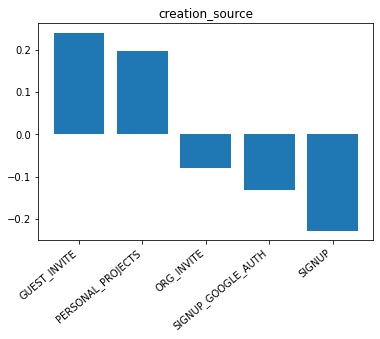

In [31]:
cat_creation_source = ['GUEST_INVITE','PERSONAL_PROJECTS' ,'ORG_INVITE', 'SIGNUP_GOOGLE_AUTH', 'SIGNUP']
X1 = encode_transform(X.creation_source, [cat_creation_source])
plt.title('creation_source')
plt.xticks([0,1,2,3,4], labels=cat_creation_source, rotation=40, ha="right")
creation_source_plot = model_plot(X1)

We can see the importance of the 'creation_sources' in terms of correlation to an adopted user. The strongest positive correlation is 0.240, for 'GUEST_INVITE'. The strongest negative correlation useful to see where non-adopted users are likely to come from is 'SIGNUP'. Stated another way, we are least likely to earn adopted users from 'SIGN_UP'. We are most likely to earn adopted users from guest invites.


**Let's check the other features.**

Feature: 0, Score: -0.02185
Feature: 1, Score: 0.02191


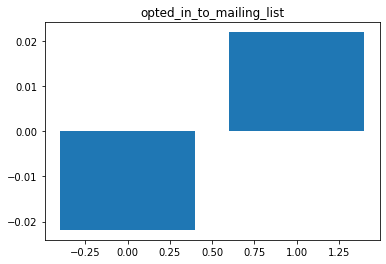

In [32]:
X1 = encode_transform(X.opted_in_to_mailing_list)
plt.title('opted_in_to_mailing_list')
model_plot(X1)

'opted_in_to_mailing_list' shows a negligable difference between adopted users. This is a weak indicator and not very useful for prediction of user adoption.

Feature: 0, Score: -0.01517
Feature: 1, Score: 0.01515


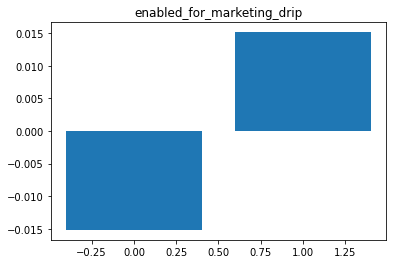

In [33]:
X1 = encode_transform(X.enabled_for_marketing_drip)	
plt.title('enabled_for_marketing_drip')
model_plot(X1)

'enabled_for_marketing_drip' shows a negligable difference between adopted users. This is also a weak indicator and not very useful for prediction of user adoption.

In [34]:
X2 = X.sort_values(by='acct_age')

In [35]:
# updated FUNCTION to store scores in a list
hey = []
hey2 = []
def model_plot2(X1):
  model = LogisticRegression()              #instantiate model
  model.fit(X1, y)                          #train model
  importance = model.coef_[0]               # get importance
  for i,v in enumerate(importance):         # summarize feature importance
    hey.append(i)
    hey2.append(v)
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

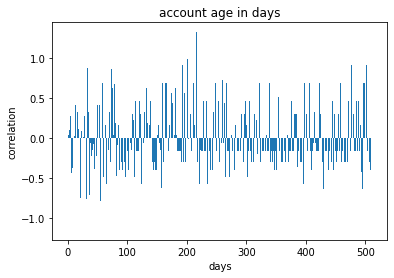

In [36]:
X1 = encode_transform(X2.acct_age)	
plt.title('account age in days')
plt.xlabel('days')
plt.ylabel('correlation')
model_plot2(X1)

In [45]:
# check the mean of the positive correlations for 'account age in days'
positive_corr = []
for i in range(len(hey)):
  if hey2[i] > 0:
    positive_corr.append(hey2[i]) 

print("The average positive correlation is:",round(np.mean(positive_corr),5))

The average positive correlation is: 0.41569


In [47]:
# check the mean of the negative correlations for 'account age in days'
negative_corr = []
for i in range(len(hey)):
  if hey2[i] < 0:
    negative_corr.append(hey2[i]) 

print("The average negative correlation is:",round(np.mean(negative_corr),5))

The average negative correlation is: -0.27988


Account age in days has the strongest positive correlation (0.4157) with user adoption. However, this is not particularly useful in predicting *future* user adoption, nor is it actionable. Some classes of Creation Source show actionable correlations. Particularly, Guest Invites and personal projects are the positively correlated creation sources. These inputs could be inferred from how the user signs-up such as whether the users is using a referral code (guest_invite, org_invite) or referral link. Marketing campaigns can be created around referrals which seems to be the most actionable information we can glean from this dataset.